#Group 32
####Nazmul Kaonine    13300912
####Minrui Li         12439586
####Fernanda Santosa  13406537

# Introduction - Food Recognition Challenge 
This dataset is originally from Food Recognition Challenge on AICrowd which can be seen from this link :  https://www.aicrowd.com/challenges/food-recognition-challenge. The dataset contains train, validation and test datasets along with the annotations. This project aims to create real-time food recognition by implementing deep learning for image classification and object detection.

## Install Required Library Versions

In [ ]:
!rm -rf images assets
!pip install numpy==1.17.0
!pip install tensorflow==1.15.2
!pip install keras==2.1.0

     |████████████████████████████████| 20.4MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 110.5MB 27kB/s 
     |████████████████████████████████| 3.8MB 37.6MB/s 
     |████████████████████████████████| 512kB 37.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=03908093bb9cb80783a677be93c6b0bc277a28bd97b68c0c5aac1aa9a550cc47
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

In [ ]:
#Original Mask RCNN Library
import os
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!pip install -q -r requirements.txt
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (566/566), done.
     |████████████████████████████████| 163kB 445kB/s 
     |████████████████████████████████| 204kB 1.0MB/s 
zip_safe flag not set; analyzing archive contents...


In [ ]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

Uninstalling pycocotools-2.0.1:
  Successfully uninstalled pycocotools-2.0.1


### Import Libraries

In [ ]:
import sys
sys.path.append(os.path.join('.', 'Mask_RCNN'))  # To find local version of the library
import sys
import re
import random
import pandas as pd 
import numpy as np
import mrcnn.model as modellib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib
import math
import logging
import json
import itertools
import glob 
import cv2
from tqdm import tqdm
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import utils
from matplotlib.patches import Polygon
from imgaug import augmenters as iaa
from collections import defaultdict, Counter
from collections import OrderedDict

Using TensorFlow backend.


#INTERPRETER

In [ ]:
#Load dataset AICrowd Food Recognition Challenge
class FoodChallengeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, load_small=False, return_coco=True):
        self.load_small = load_small
        if self.load_small:
            annotation_path = os.path.join(dataset_dir, "annotation-small.json") #Small subset of image annotations
        else:
            annotation_path = os.path.join(dataset_dir, "annotations.json") #Image annotations

        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        #Load all classes)
        classIds = self.coco.getCatIds()

        #Load all images
        image_ids = list(self.coco.imgs.keys())

        #Register classes
        for _class_id in classIds:
            self.add_class("crowdai-food-challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        #Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "crowdai-food-challenge", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id): #Converts mask from COCO format to bitmap such as height, width, distance. imagd_id is image refence id
        image_info = self.image_info[image_id]
        assert image_info["source"] == "crowdai-food-challenge"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        #Create shape masks based on images height and width, also with the class IDS
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "crowdai-food-challenge.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                #If the object is smaller than 1 pixel, the system will skip that objects
                if m.max() < 1:
                    continue
                instance_masks.append(m)
                class_ids.append(class_id)
        #Create shape masks as an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            #Super to refer parent classes
            return super(FoodChallengeDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        #Change URL return to image ID
        return "crowdai-food-challenge::{}".format(image_id)

    def annToRLE(self, ann, height, width):
        #Decode Run Length Encoding to binary mask 2D array
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        #Convert to Binary Mask
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [ ]:
#Food Challenge AI Crowd configuration
from mrcnn.config import Config
class FoodChallengeConfig(Config):
    #Config Name
    NAME = "crowdai-food-challenge"
    IMAGES_PER_GPU = 8
    #Default GPU = 1
    GPU_COUNT = 1
    BACKBONE = 'resnet50'
    # Number of classes including background
    NUM_CLASSES = 62  # 61 classes + 1 background
    STEPS_PER_EPOCH=50
    VALIDATION_STEPS=5
    IMAGE_RESIZE_MODE = "crop"
    LEARNING_RATE=0.002
    IMAGE_MAX_DIM=128
    IMAGE_MIN_DIM=128
config = FoodChallengeConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [ ]:
%cd ..
!cp /kaggle/input/food-recognition-challenge /kaggle/working -r
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

/content
cp: cannot stat '/kaggle/input/food-recognition-challenge': No such file or directory


In [ ]:
#Copy annotations json files
!cp /kaggle/working/food-recognition-challenge/train/train/annotations.json /kaggle/working/food-recognition-challenge/train/train/annotation.json

cp: cannot stat '/kaggle/working/food-recognition-challenge/train/train/annotations.json': No such file or directory


In [ ]:
#Retrieves train and validation dataset
os.system('wget -P /content/ https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/train.tar.gz')
os.system('wget -P /content/ https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/val.tar.gz')

0

In [ ]:
#Make new directories
!mkdir /kaggle
!mkdir /kaggle/working/
!mkdir /kaggle/working/food-recognition-challenge
!mkdir /kaggle/working/food-recognition-challenge/train
!mkdir /kaggle/working/food-recognition-challenge/train/train

In [ ]:
#Contents on train dataset
!tar -xvf  '/content/train.tar.gz' -C '/kaggle/working/food-recognition-challenge/train/train'

Streaming output truncated to the last 5000 lines.
./images/021681.jpg
./images/._018000.jpg
./images/018000.jpg
./images/._008213.jpg
./images/008213.jpg
./images/._027596.jpg
./images/027596.jpg
./images/._017455.jpg
./images/017455.jpg
./images/._023928.jpg
./images/023928.jpg
./images/._025395.jpg
./images/025395.jpg
./images/._043010.jpg
./images/043010.jpg
./images/._035186.jpg
./images/035186.jpg
./images/._045461.jpg
./images/045461.jpg
./images/._039964.jpg
./images/039964.jpg
./images/._037791.jpg
./images/037791.jpg
./images/._048145.jpg
./images/048145.jpg
./images/._011030.jpg
./images/011030.jpg
./images/._033291.jpg
./images/033291.jpg
./images/._023082.jpg
./images/023082.jpg
./images/._043945.jpg
./images/043945.jpg
./images/._029222.jpg
./images/029222.jpg
./images/._070357.jpg
./images/070357.jpg
./images/._039031.jpg
./images/039031.jpg
./images/._021118.jpg
./images/021118.jpg
./images/._039757.jpg
./images/039757.jpg
./images/._018799.jpg
./images/018799.jpg
./ima

In [ ]:
#Create new directories
!mkdir /kaggle/working/food-recognition-challenge/val
!mkdir /kaggle/working/food-recognition-challenge/val/val

In [ ]:
#Contents on validation dataset
!tar -xvf  '/content/val.tar.gz' -C '/kaggle/working/food-recognition-challenge/val/val'

._.
./
./._test_images
./test_images/
./._images
./images/
./._annotations.json
./annotations.json
./images/._063436.jpg
./images/063436.jpg
./images/._049591.jpg
./images/049591.jpg
./images/._065537.jpg
./images/065537.jpg
./images/._047972.jpg
./images/047972.jpg
./images/._028580.jpg
./images/028580.jpg
./images/._008678.jpg
./images/008678.jpg
./images/._056710.jpg
./images/056710.jpg
./images/._067240.jpg
./images/067240.jpg
./images/._021573.jpg
./images/021573.jpg
./images/._067254.jpg
./images/067254.jpg
./images/._066604.jpg
./images/066604.jpg
./images/._069523.jpg
./images/069523.jpg
./images/._062847.jpg
./images/062847.jpg
./images/._009002.jpg
./images/009002.jpg
./images/._061427.jpg
./images/061427.jpg
./images/._007952.jpg
./images/007952.jpg
./images/._038209.jpg
./images/038209.jpg
./images/._028998.jpg
./images/028998.jpg
./images/._059813.jpg
./images/059813.jpg
./images/._030696.jpg
./images/030696.jpg
./images/._012190.jpg
./images/012190.jpg
./images/._015199.j

In [ ]:
#From mrcnn.dataset import FoodChallengeDataset
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(dataset_dir=os.path.join("/kaggle/working/food-recognition-challenge/train", "train"), load_small=False)
dataset_train.prepare()
dataset = dataset_train

Annotation Path  /kaggle/working/food-recognition-challenge/train/train/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/train/train/images
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


# IMAGE COUNT ON TRAIN DATASET

In [ ]:
from collections import Counter
class_counts = Counter()
for img_info in dataset_train.image_info:
    ann = img_info['annotations']
    for i in ann:
        class_counts[i['category_id']] += 1
class_mapping = {i['id']: i['name'] for i in dataset_train.class_info}

class_counts = pd.DataFrame(class_counts.most_common(), columns=['class_name', 'count'])
class_counts['class_name'] = class_counts['class_name'].apply(lambda x: class_mapping[x])
plt.figure(figsize=(12, 12))
plt.barh(class_counts['class_name'], class_counts['count'])
plt.title('Counts of classes of objects');

In [ ]:
print(f'We have {class_counts.shape[0]} classes!')

We have 61 classes!


In [ ]:
class_names = dataset_train.class_names
assert len(class_names)==62, "Please check DatasetConfig"

In [ ]:
class_names

['BG',
 'water',
 'pizza-margherita-baked',
 'broccoli',
 'salad-leaf-salad-green',
 'zucchini',
 'egg',
 'butter',
 'bread-white',
 'apple',
 'dark-chocolate',
 'white-coffee-with-caffeine',
 'sweet-pepper',
 'mixed-salad-chopped-without-sauce',
 'tomato-sauce',
 'bread-wholemeal',
 'coffee-with-caffeine',
 'cucumber',
 'cheese',
 'pasta-spaghetti',
 'rice',
 'salmon',
 'carrot',
 'onion',
 'mixed-vegetables',
 'espresso-with-caffeine',
 'banana',
 'strawberries',
 'mayonnaise',
 'almonds',
 'wine-white',
 'hard-cheese',
 'ham-raw',
 'tomato',
 'french-beans',
 'mandarine',
 'wine-red',
 'potatoes-steamed',
 'croissant',
 'salami',
 'boisson-au-glucose-50g',
 'biscuits',
 'corn',
 'leaf-spinach',
 'jam',
 'tea-green',
 'chips-french-fries',
 'parmesan',
 'beer',
 'avocado',
 'bread-french-white-flour',
 'chicken',
 'soft-cheese',
 'tea',
 'sauce-savoury',
 'honey',
 'bread-whole-wheat',
 'bread-sourdough',
 'gruyere',
 'pickle',
 'mixed-nuts',
 'water-mineral']

In [ ]:
#Image count on train dataset
print('Train: %d' % len(dataset_train.image_ids))

Train: 7949


# Data Exploration

In [ ]:
#Load random image and masks from the repo
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
#Extract the bounding boxes
bbox = utils.extract_bboxes(mask)
#Display image informations
print("image_id ", image_id, dataset.image_reference(image_id))

image_id  64 crowdai-food-challenge::64


###Check Image Annotation Information

In [ ]:
#Check image annotation informations
dataset_train.image_info[0]

Based on what we discovered from annotation, it provides class ids, segmentation mask, total area, bbox coordinates for each images

#SOME VISUALIZATIONS

image                    shape: (972, 973, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (972, 973, 3)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (3,)                  min:    8.00000  max:   22.00000  int32
bbox                     shape: (3, 4)                min:    3.00000  max:  925.00000  int32


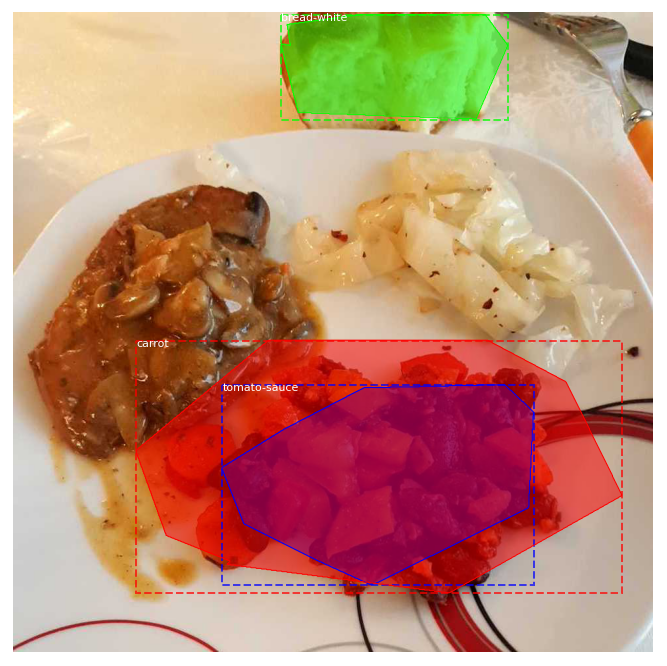

In [ ]:
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
#Image visualisation
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(12, 12))

#Masks

In [ ]:
class_images = defaultdict(list)
for ind, img_info in enumerate(dataset_train.image_info):
    ann = img_info['annotations']
    for i in ann:
        class_images[i['category_id']].append(ind)

In [ ]:
image_ids = np.random.choice(dataset.image_ids, 4)
for class_id in np.random.choice(list(class_images.keys()), 10):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Check Bounding Boxes

In [ ]:
for idx, class_id in enumerate(np.random.choice(list(class_images.keys()), 10)):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(8, 8))

Bounding boxes contain different masks, depends on how many items on each image.

# Exploring Image Anchors

Retrieve the scale and aspect ratio of particular object classes that we detect and depends on the object sizes from the train datasets.

In [ ]:
#Create anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

#Anchor Informations
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  4092
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 3072
Anchors in Level 1: 768
Anchors in Level 2: 192
Anchors in Level 3: 48
Anchors in Level 4: 12


In [ ]:
#Load random image for anchor visualisation
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    #Compute anchor index at the center of the image
    level_start = sum(anchors_per_level[:level])
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [ ]:
#Random data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)
#Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]

#Remove last dimension
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

b = 0

#Restore original image
sample_image = modellib.unmold_image(normalized_images[b], config)

#Compute anchor movements
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)

#Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]

#ROI, ordered by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

#Show achors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

# Trying to find ROI Informations
To perform multiple object detection using CNN. Max Pooling from multi sizes input and obtain fixed-size feature maps in order to gain some understanding what elements that CNN detects and saves time to process the images.

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

## Now We are Going to build Mask-RCNN Model

In [ ]:
#Set file directory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Make new directory for pretrained model
!mkdir pretrained

## We retrieve the pretrained mask-rcnn-coco model

In [ ]:
#We used pretrained mask-rcnn coco model 
PRETRAINED_MODEL_PATH = os.path.join("pretrained", "mask_rcnn_coco.h5")
LOGS_DIRECTORY = ('/content/drive/My Drive/DL_A3/logs')
if not os.path.exists(PRETRAINED_MODEL_PATH):
    utils.download_trained_weights(PRETRAINED_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
#Use the pretrained model on our training model
import keras.backend
K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.common.image_dim_ordering()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








## Preparing Train Dataset

In [ ]:
#Prepare train dataset
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(os.path.join("/kaggle/working/food-recognition-challenge/train", "train"), load_small=False)
dataset_train.prepare()
dataset_val = FoodChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir=os.path.join("/kaggle/working/food-recognition-challenge/val", "val"), load_small=False, return_coco=True)
dataset_val.prepare()

Annotation Path  /kaggle/working/food-recognition-challenge/train/train/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/train/train/images
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Annotation Path  /kaggle/working/food-recognition-challenge/val/val/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/val/val/images
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
#Subset of train dataset
print('Val: %d' % len(dataset_val.image_ids))

Val: 418


In [ ]:
#Define class names on the dataset
class_names = dataset_train.class_names
assert len(class_names)==62, "Please check DatasetConfig"

## We built the training model that is going to be implemnted to build Prediction Model

In [ ]:
#print("Training network")
#model.train(dataset_train, dataset_val,
            #learning_rate=config.LEARNING_RATE,
            #epochs=10,
            #layers='heads')

In [ ]:
#model_path = model.find_last()
#model_path

In [ ]:
#Trained model locally
model_path = '/content/drive/My Drive/DL_A3/Other Logs/mask_final.h5'

## We have to set Model Prediction Configuration Settings


In [ ]:
#Set Prediction Model Conigurations
class InferenceConfig(FoodChallengeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 62  # 1 Background + 61 classes
    IMAGE_MAX_DIM=1024
    IMAGE_MIN_DIM=512
    NAME = "food"
    DETECTION_MIN_CONFIDENCE=0
   
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

In [ ]:
#Set model directory
#h5_dir=LOGS_DIRECTORY
#h5_dir='/content/drive/My Drive/DL_A3/logs'
h5_dir='/content/drive/My Drive/DL_A3/OtherLogs'

In [ ]:
#Recreate model on inference mode; using pretrained model
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=h5_dir)

#Load trained weights
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/DL_A3/Other Logs/mask_rcnn_crowdai-food-challenge_0015.h5


# Here is the Prediction Model Result with Image Ground Truth using Validation Dataset

(512, 512, 3)
['bread-white']
['bread-white']
(512, 512, 3)
['water']
(512, 512, 3)
['bread-wholemeal']
['butter']
(512, 512, 3)
['water']


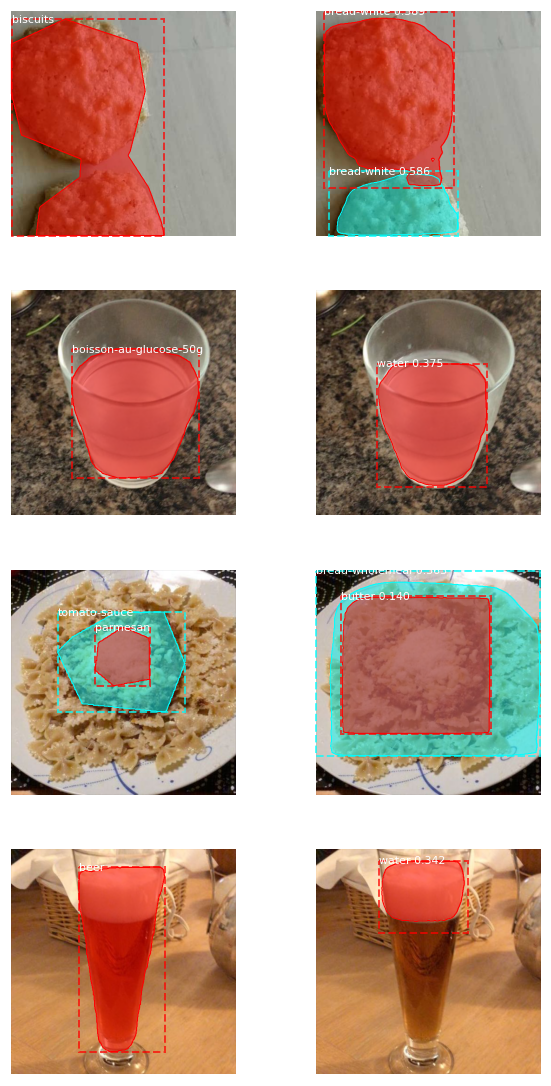

In [ ]:
#Visualise examples of Image Ground Truth vs. Predictions using Validation Dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])
    
    for i in r['class_ids']:
     print([class_names[i]])

In [ ]:
class_names [24]

'mixed-vegetables'

#Getting Nutrients

In [ ]:
nutrients= pd.read_csv( "/content/drive/My Drive/DL_A3/nutrients/food_nutrient.csv" )
nutrients.head(10)

,class_name,name,energy_kcal,serving_size,protein_g,carb_g,fat_g,glycemicIndex_GI
0,water,water,0.0,250ml,0.00,0.00,0.00,NaN
1,pizza-margherita-baked,margherita pizza,868.0,2 slice,47.50,120.90,26.00,80.0
2,broccoli,broccoli,31.0,1 cup,2.50,6.00,0.40,10.0
3,salad-leaf-salad-green,green salad leaf,8.0,1 cup,0.60,1.50,0.10,15.0
4,zucchini,zucchini,17.0,1 cup,1.00,3.00,0.00,15.0
5,egg,egg,72.0,each large egg (50g),6.30,0.40,4.80,20.0
6,butter,butter,102.0,1 tbsp (14.2g),0.12,0.01,11.50,50.0
7,bread-white,white bread,67.0,1 slice (25g),2.00,13.00,1.00,75.0
8,apple,apple,52.0,100g,0.30,13.80,0.20,36.0
9,dark-chocolate,dark chocolate,604.0,101g,7.87,24.23,43.06,23.0


(512, 512, 3)
['salad-leaf-salad-green']
4
The nutrients are:  class_name          salad-leaf-salad-green
name                      green salad leaf
energy_kcal                              8
serving_size                        1 cup 
protein_g                              0.6
carb_g                                 1.5
fat_g                                  0.1
glycemicIndex_GI                        15
Name: 3, dtype: object
['bread-wholemeal']
15
The nutrients are:  class_name             bread-wholemeal
name                   wholemeal bread
energy_kcal                         92
serving_size        1 thin slice (33g)
protein_g                            3
carb_g                              17
fat_g                                2
glycemicIndex_GI                    74
Name: 14, dtype: object
['bread-white']
8
The nutrients are:  class_name            bread-white
name                  white bread
energy_kcal                    67
serving_size        1 slice (25g)
protein_g        

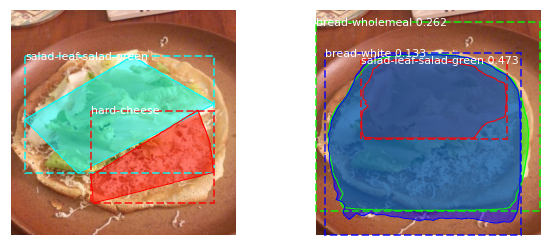

In [ ]:
#Visualise examples of Image Ground Truth vs. Predictions using Validation Dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(1):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])
    
    for i in r['class_ids']:
     print([class_names[i]])
     print(i)
     print("The nutrients are: ", nutrients.iloc[i-1]) #checking the class name

In [ ]:
class_names[i]

'water'